In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=100)


from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris, fetch_lfw_people, load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
def pca(A,n_components=2):
    '''
    Perform principal component analysis on a matrix A and
    return the desired principal components
    '''

    U,S,Vh = np.linalg.svd(A, full_matrices=False)

    return A@Vh[:,:n_components]

In [3]:
# import data
# iris
iris = load_iris()

iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris.data, iris.target, test_size=.5
)

# breast cancer
can = load_breast_cancer()

can_X_train, can_X_test, can_y_train, can_y_test = train_test_split(
    can.data, can.target, test_size=.5
)

# faces
peo = fetch_lfw_people()

peo_X_train, peo_X_test, peo_y_train, peo_y_test = train_test_split(peo.data, peo.target, test_size=.7)

In [4]:
def plot_data(X, y, classes, title):

    for c in range(classes):
        mask = y == c

        plt.scatter(X[mask, 0], X[mask, 1], label=f'type {c}',marker='.',lw=.3)
        plt.legend()
        plt.title(title)
    plt.savefig(f'./images/{title}.pdf')
    plt.show()

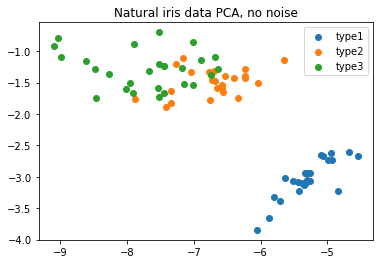

Iris + random forest baseline = 0.7066666666666667
Iris + K-Neighbors baseline = 0.72


In [5]:
# give background on how well PCA works for each data set
trans_iris_train = pca(iris_X_train)
trans_iris_test = pca(iris_X_test)

c1 = iris_y_train == 0
c2 = iris_y_train == 1
c3 = iris_y_train == 2

plt.scatter(trans_iris_train[c1,0], trans_iris_train[c1,1], label='type1')
plt.scatter(trans_iris_train[c2,0], trans_iris_train[c2,1], label='type2')
plt.scatter(trans_iris_train[c3,0], trans_iris_train[c3,1], label='type3')
plt.title('Natural iris data PCA, no noise')
plt.savefig('Unaltered_iris.pdf')
plt.legend()
plt.show()

RFC = RandomForestClassifier(n_estimators=50, max_depth=10)
RFC = RFC.fit(trans_iris_train, iris_y_train)
score = sum(RFC.predict(trans_iris_test) == iris_y_test) / len(iris_y_test)
print(f'Iris + random forest baseline = {score}')

KNC = KNeighborsClassifier(n_neighbors=3)
KNC.fit(trans_iris_train, iris_y_train)
score = sum(KNC.predict(trans_iris_test) == iris_y_test) / len(iris_y_test)
print(f'Iris + K-Neighbors baseline = {score}')

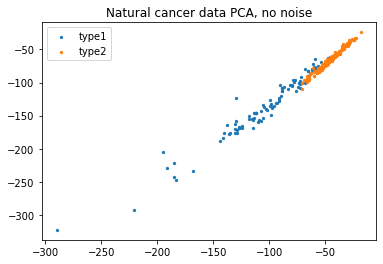

Cancer + random forest baseline = 0.6175438596491228
Cancer + K-Neighbors baseline = 0.6175438596491228


In [50]:
trans_can_train = pca(can_X_train)
trans_can_test = pca(can_X_test)
c1 = can_y_train == 0
c2 = can_y_train == 1


plt.scatter(trans_can_train[c1,0], trans_can_train[c1,1], label='type1',marker='.',lw=.3)
plt.scatter(trans_can_train[c2,0], trans_can_train[c2,1], label='type2',marker='.',lw=.3)
plt.title('Natural cancer data PCA, no noise')
plt.legend()
plt.savefig('Unaltered_cancer.pdf')
plt.show()

RFC = RandomForestClassifier(**{'n_estimators':20, 'max_depth':10})
RFC.fit(trans_can_train, can_y_train)
score = sum(RFC.predict(trans_can_test) == can_y_test) / len(can_y_test)
print(f'Cancer + random forest baseline = {score}')

KNC = KNeighborsClassifier(**{'n_neighbors':3})
KNC.fit(trans_can_train, can_y_train)
score = sum(KNC.predict(trans_can_test) == can_y_test) / len(can_y_test)
print(f'Cancer + K-Neighbors baseline = {score}')

In [32]:
def noiser(A,noise,params):
    '''

    Add noise of type `noise` to the data
    noise may be:
        normal, beta, student-t, uniform,
        gamma
    '''

    noise_dict = {
        'normal': stats.norm, 'student-t': stats.t,
        'beta': stats.beta, 'gamma': stats.gamma,
        'uniform': stats.uniform
    }

    n_func = noise_dict[noise](*params)


    return A + n_func.rvs(A.shape)

In [33]:
# set up the parameters grids I will use to test PCA
beta_params = {
    'a': np.linspace(.1,5,15),
    'b': np.linspace(.1,5,15)
}
normal_params = {
    'mean': np.linspace(-1,1,15),
    'std': np.linspace(0,1,15)
}
uniform_params = {
    'a': np.linspace(0,2,15),
    'length': np.linspace(.5,2,15) 
}
student_t_params = {
    'df': np.linspace(.2,7,100),
    'mean': np.linspace(0,10,50),
    'std': np.linspace(0,10,20)
}
gamma_params = {
    'a': np.linspace(.1,10,15),
    'scale': np.linspace(.1,10,15)
}

In [34]:
def beta_testing(X_train,y_train,X_test,y_test,n,Classifier,params,plot=True):
    # do beta testing
    as_ = beta_params['a']
    bs = beta_params['b']
    i=0

    scores = np.zeros((len(as_)*len(bs),3))
    

    for a in as_:
        for b in bs:
            # first we apply noise
            X_train_noise = noiser(X_train, 'beta', (a,b))
            X_test_noise = noiser(X_test, 'beta', (a,b))

            # next we apply pca
            train_data = pca(X_train_noise)
            test_data = pca(X_test_noise)

            # finally we test and train a classifier and examine the 
            # score
            classifier = Classifier(**params)
            classifier.fit(train_data, y_train)

            # score the classifier and record it 
            score = sum(classifier.predict(test_data) == y_test) / len(y_test)
            scores[i] = (a,b,score)


            # every once and a while we plot the results
            if i%25 == 0 and plot:
                title_format = 'Beta: a={a:.2f}, b={b:.2f}, score={score:.2f}'
                title = title_format.format(a=a, b=b, score=scores[i,2])
                plot_data(train_data, y_train, n, title)


            i+=1

    return scores

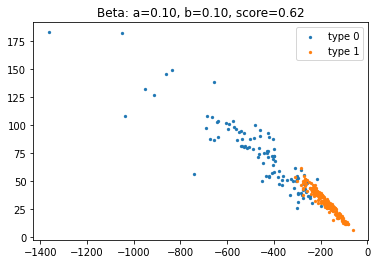

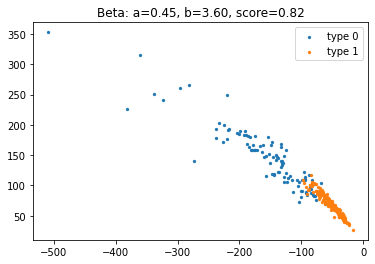

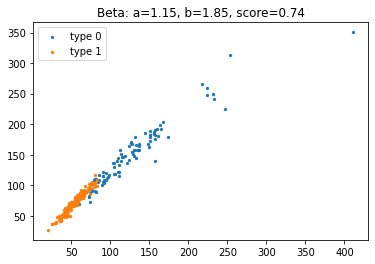

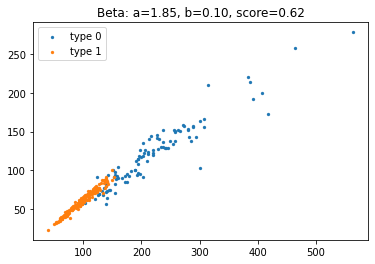

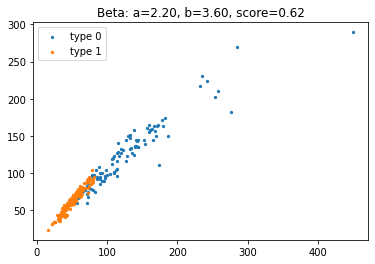

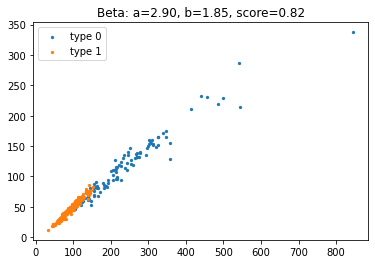

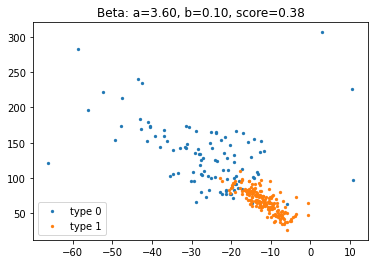

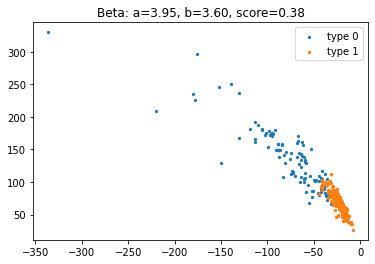

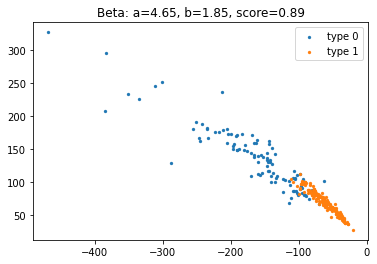


BETA NOISE WITH RANDOM FOREST

The 10 best performing parameters are :
	a	b	score
	--------------------
	4.65&	1.85&	0.891\\
	2.55&	0.10&	0.888\\
	3.95&	4.65&	0.881\\
	0.80&	3.60&	0.881\\
	4.65&	1.15&	0.877\\
	2.55&	4.30&	0.874\\
	2.90&	0.10&	0.874\\
	1.50&	4.30&	0.867\\
	4.30&	5.00&	0.867\\
	0.80&	5.00&	0.863\\

The 10 worst performing parameters are :
	a	b	score
	--------------------
	1.15&	3.95&	0.382\\
	2.55&	1.15&	0.382\\
	3.95&	1.15&	0.382\\
	3.95&	2.20&	0.382\\
	3.95&	3.60&	0.382\\
	3.95&	5.00&	0.382\\
	0.80&	0.45&	0.382\\
	2.90&	3.60&	0.382\\
	3.95&	0.80&	0.382\\
	2.55&	2.20&	0.309\\


In [35]:
# test beta with random forest
# get the scores
scores = beta_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    RandomForestClassifier, {'n_estimators':50, 'max_depth':10}
)

print('\nBETA NOISE WITH RANDOM FOREST\n')

# print the best results
best_performance = np.argsort(scores[:,2])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    a,b,score = scores[best]
    print(row_format.format(a=a,b=b,score=score))

print()

# print the worst results
worst_performance = np.argsort(scores[:,2])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    a,b,score = scores[worst]
    print(row_format.format(a=a,b=b,score=score))

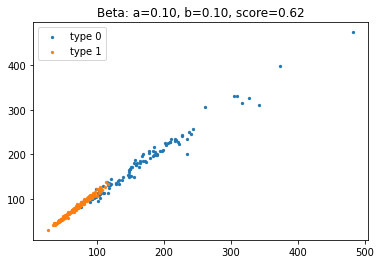

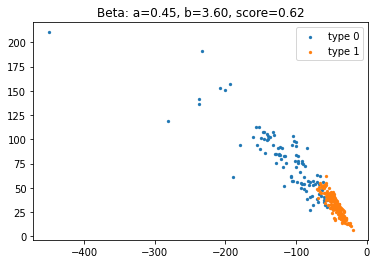

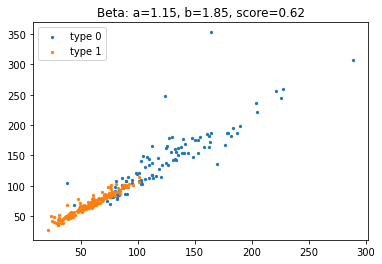

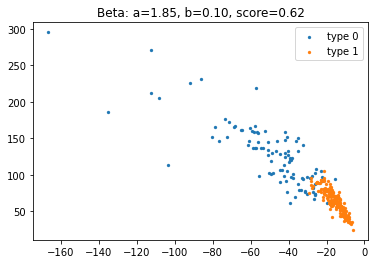

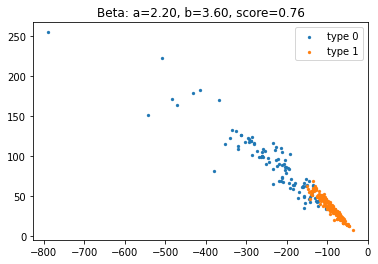

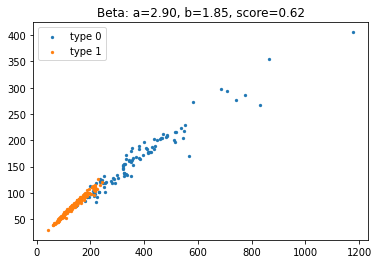

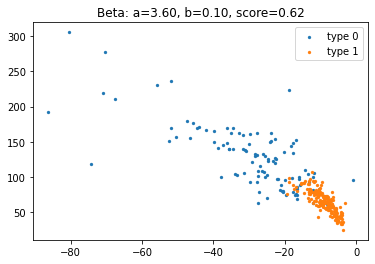

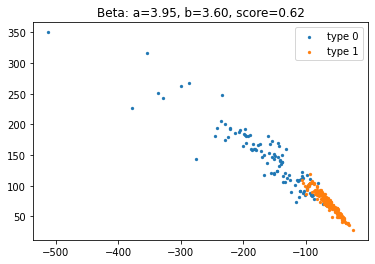

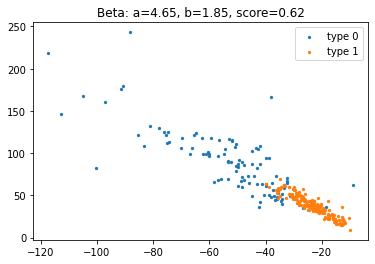


BETA NOISE WITH K-NEIGHBORS

The 10 best performing parameters are :
	a	b	score
	--------------------
	4.30&	4.65&	0.919\\
	4.30&	1.50&	0.909\\
	0.10&	1.50&	0.902\\
	1.85&	3.95&	0.902\\
	1.50&	1.85&	0.902\\
	1.15&	3.25&	0.898\\
	0.45&	4.30&	0.895\\
	0.45&	1.50&	0.895\\
	0.45&	0.45&	0.881\\
	1.15&	0.80&	0.870\\

The 10 worst performing parameters are :
	a	b	score
	--------------------
	1.15&	4.65&	0.484\\
	3.95&	1.85&	0.474\\
	4.30&	1.85&	0.463\\
	1.85&	2.55&	0.442\\
	4.65&	2.90&	0.421\\
	0.80&	1.15&	0.418\\
	1.85&	4.30&	0.411\\
	1.85&	1.50&	0.400\\
	3.60&	5.00&	0.386\\
	0.10&	1.85&	0.382\\


In [36]:
# test beta with k-neighbors classifier
scores = beta_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    KNeighborsClassifier, {'n_neighbors':3}, plot=True
)

print('\nBETA NOISE WITH K-NEIGHBORS\n')

# print the best results
best_performance = np.argsort(scores[:,2])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    a,b,score = scores[best]
    print(row_format.format(a=a,b=b,score=score))

print()

# print the worst results
worst_performance = np.argsort(scores[:,2])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    a,b,score = scores[worst]
    print(row_format.format(a=a,b=b,score=score))

In [37]:
# do normal testing
def normal_testing(X_train,y_train,X_test,y_test,n,Classifier,params,plot=True):


    means = normal_params['mean']
    stds = normal_params['std']
    i=0
    scores = np.zeros((len(means)*len(stds),3))
    

    for mean in means:
        for std in stds:
            # first we apply noise
            X_train_noise = noiser(X_train, 'normal', (mean,std))
            X_test_noise = noiser(X_test, 'normal', (mean,std))

            # next we apply pca
            train_data = pca(X_train_noise)
            test_data = pca(X_test_noise)

            # finally we test and train a classifier and examine the 
            # score
            classifier = Classifier(**params)
            classifier.fit(train_data, y_train)

            # score the classifier and record it 
            score = sum(classifier.predict(test_data) == y_test) / len(y_test)
            scores[i] = (mean,std,score)

            # every once and a while we plot the results
            if i%25 == 0 and plot:
                title_format = 'Normal: $\mu$={a:.2f}, $\sigma$={b:.2f}, score={score:.2f}'
                title = title_format.format(a=mean, b=std, score=scores[i,2])
                plot_data(train_data, y_train, n, title)


            i+=1

    return scores

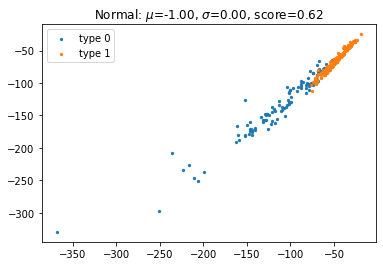

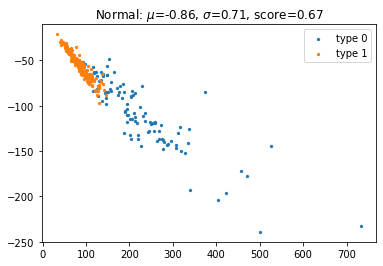

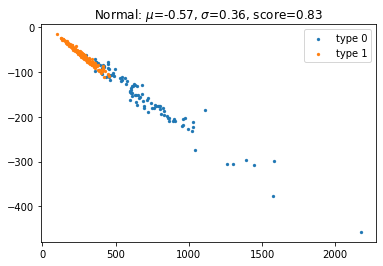

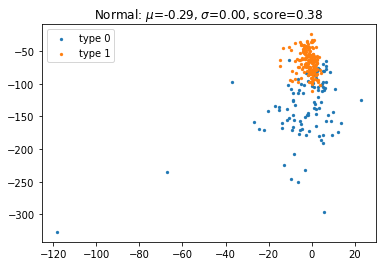

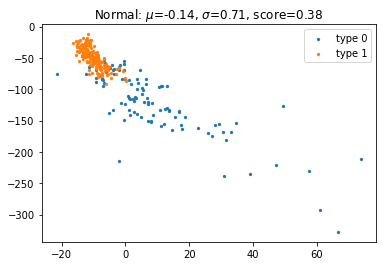

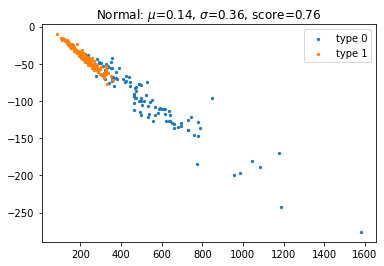

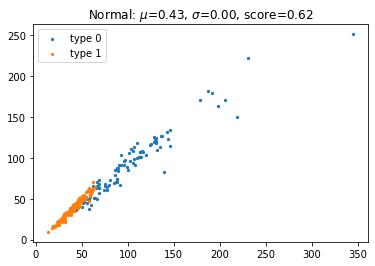

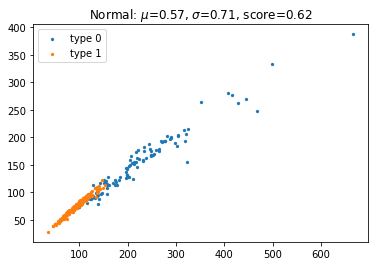

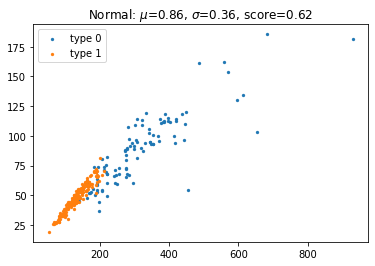


NORMAL NOISE WITH RANDOM FOREST

The 10 best performing parameters are :
	Mean	Std	score
	--------------------
	1.00&	0.71&	0.916\\
	0.86&	0.57&	0.912\\
	-0.29&	0.71&	0.912\\
	-0.43&	0.86&	0.909\\
	0.00&	0.21&	0.898\\
	-0.71&	0.21&	0.891\\
	0.00&	0.79&	0.891\\
	-0.86&	0.86&	0.891\\
	0.29&	0.36&	0.888\\
	0.86&	0.71&	0.877\\

The 10 worst performing parameters are :
	Mean	Std	score
	--------------------
	0.43&	0.36&	0.382\\
	-0.29&	0.00&	0.382\\
	0.14&	0.43&	0.382\\
	-0.29&	0.43&	0.382\\
	-0.14&	0.71&	0.382\\
	-0.71&	0.29&	0.382\\
	-0.29&	0.64&	0.382\\
	0.29&	0.79&	0.382\\
	-0.14&	0.93&	0.382\\
	-0.43&	0.57&	0.382\\


In [38]:
# test normal with random forest
# get the scores
scores = normal_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    RandomForestClassifier, {'n_estimators':50, 'max_depth':10}
)

print('\nNORMAL NOISE WITH RANDOM FOREST\n')

# print the best results
best_performance = np.argsort(scores[:,2])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\tMean\tStd\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    a,b,score = scores[best]
    print(row_format.format(a=a,b=b,score=score))

print()

# print the worst results
worst_performance = np.argsort(scores[:,2])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\tMean\tStd\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    a,b,score = scores[worst]
    print(row_format.format(a=a,b=b,score=score))

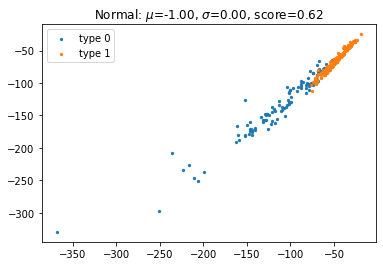

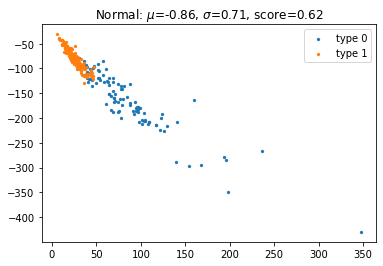

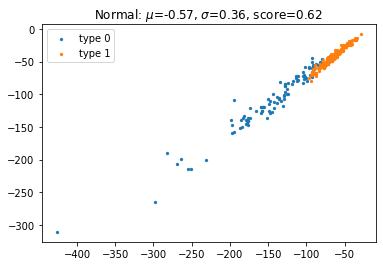

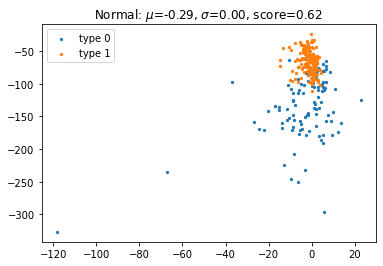

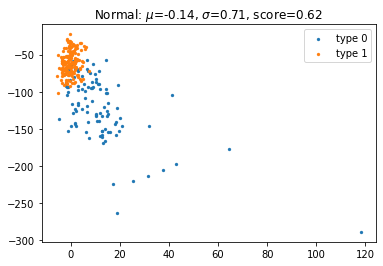

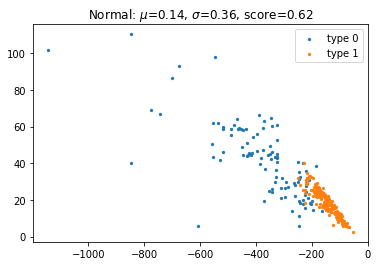

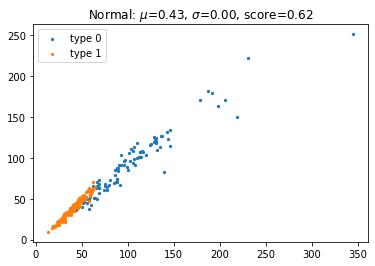

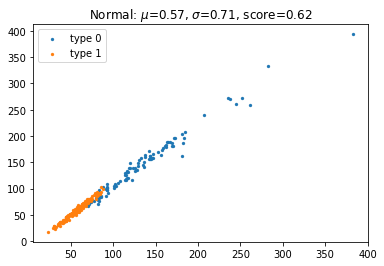

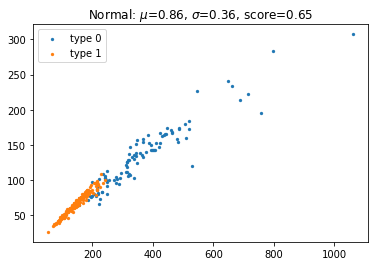


NORMAL NOISE WITH K-NEIGHBORS

The 10 best performing parameters are :
	Mean	Std	score
	--------------------
	0.14&	0.14&	0.930\\
	1.00&	0.57&	0.912\\
	-0.71&	0.43&	0.905\\
	-0.14&	0.50&	0.905\\
	-0.86&	0.79&	0.902\\
	0.86&	0.50&	0.902\\
	-0.43&	0.64&	0.895\\
	0.57&	0.50&	0.884\\
	-0.71&	0.64&	0.874\\
	-0.29&	0.57&	0.867\\

The 10 worst performing parameters are :
	Mean	Std	score
	--------------------
	0.14&	0.21&	0.477\\
	1.00&	0.50&	0.442\\
	0.57&	0.93&	0.425\\
	0.00&	0.71&	0.421\\
	-0.14&	0.79&	0.421\\
	0.71&	0.93&	0.400\\
	0.43&	0.71&	0.396\\
	-0.29&	0.79&	0.386\\
	0.14&	1.00&	0.382\\
	-0.43&	0.50&	0.382\\


In [39]:
# test normal with k-neighbors classifier
scores = normal_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    KNeighborsClassifier, {'n_neighbors':3}, plot=True
)

print('\nNORMAL NOISE WITH K-NEIGHBORS\n')

# print the best results
best_performance = np.argsort(scores[:,2])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\tMean\tStd\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    a,b,score = scores[best]
    print(row_format.format(a=a,b=b,score=score))

print()

# print the worst results
worst_performance = np.argsort(scores[:,2])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\tMean\tStd\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    a,b,score = scores[worst]
    print(row_format.format(a=a,b=b,score=score))

In [40]:
# do student t testing
def student_t_testing(X_train,y_train,X_test,y_test,n,Classifier,params,plot=True):


    dfs = student_t_params['df']
    i=0
    scores = np.zeros((len(dfs),2))
    

    for df in dfs:
            # first we apply noise
            X_train_noise = noiser(X_train, 'student-t', (df,))
            X_test_noise = noiser(X_test, 'student-t', (df,))

            # next we apply pca
            train_data = pca(X_train_noise)
            test_data = pca(X_test_noise)

            # finally we test and train a classifier and examine the 
            # score
            classifier = Classifier(**params)
            classifier.fit(train_data, y_train)

            # score the classifier and record it 
            score = sum(classifier.predict(test_data) == y_test) / len(y_test)
            scores[i] = (df,score)

            # every once and a while we plot the results
            if i%25 == 0 and plot:
                title_format = 'Student-t: df={a:.2f} score={score:.2f}'
                title = title_format.format(a=df, score=scores[i,1])
                plot_data(train_data, y_train, n, title)


            i+=1

    return scores

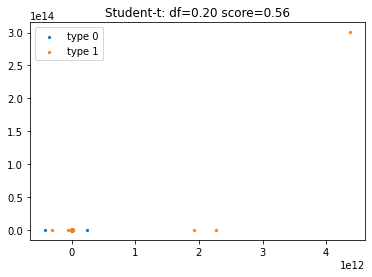

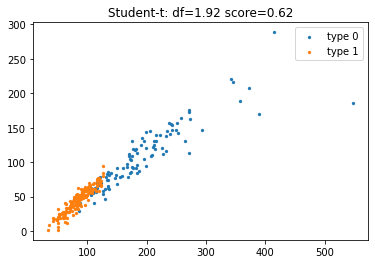

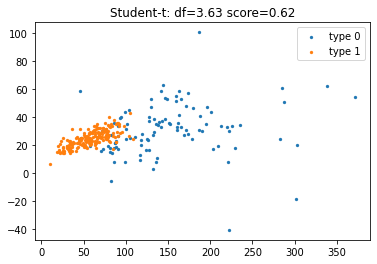

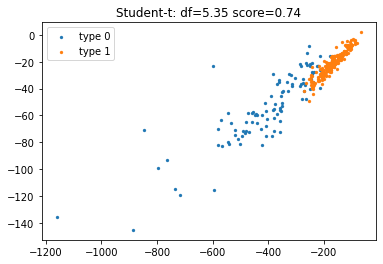


STUDENT-T WITH RANDOM FOREST

The 10 best performing parameters are :
	df	score
	------------------
	4.66&	0.898\\
	6.79&	0.895\\
	3.15&	0.891\\
	3.22&	0.884\\
	4.53&	0.881\\
	3.43&	0.867\\
	4.12&	0.860\\
	4.94&	0.832\\
	1.37&	0.804\\
	3.91&	0.779\\
The 10 worst performing parameters are :
	df	score
	------------------
	4.60&	0.396\\
	1.51&	0.396\\
	4.18&	0.396\\
	3.08&	0.393\\
	5.56&	0.382\\
	6.66&	0.382\\
	3.02&	0.382\\
	4.25&	0.382\\
	5.21&	0.382\\
	0.68&	0.211\\


In [41]:
# test student-t with random forest
# get the scores
scores = student_t_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    RandomForestClassifier, {'n_estimators':50, 'max_depth':10}
)

print('\nSTUDENT-T WITH RANDOM FOREST\n')

# print the best results
best_performance = np.argsort(scores[:,1])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\tdf\tscore')
print('\t'+'--'*len('\tdf\tscore'))
row_format = '\t{a:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    df,score = scores[best]
    print(row_format.format(a=df,score=score))

# print the worst results
worst_performance = np.argsort(scores[:,1])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\tdf\tscore')
print('\t'+'--'*len('\tdf\tscore'))
row_format = '\t{a:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    df,score = scores[worst]
    print(row_format.format(a=df,score=score))

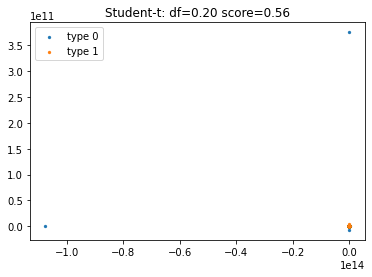

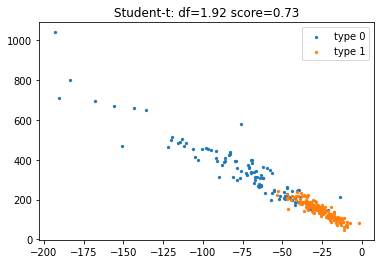

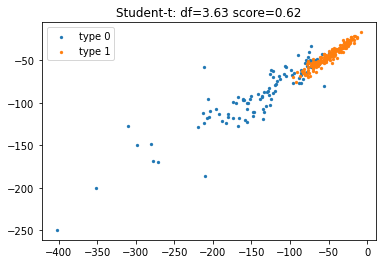

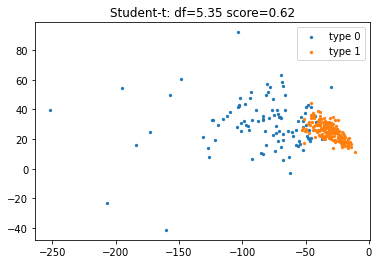


STUDENT-T WITH K-NEIGHBORS

The 10 best performing parameters are :
	df	score
	------------------
	6.38&	0.923\\
	2.67&	0.916\\
	6.59&	0.902\\
	6.73&	0.898\\
	1.23&	0.877\\
	3.15&	0.863\\
	5.28&	0.860\\
	1.99&	0.853\\
	2.19&	0.853\\
	6.31&	0.846\\
The 10 worst performing parameters are :
	df	score
	------------------
	4.05&	0.477\\
	2.05&	0.442\\
	0.89&	0.404\\
	5.97&	0.396\\
	4.66&	0.393\\
	4.53&	0.393\\
	5.15&	0.386\\
	1.02&	0.386\\
	3.77&	0.386\\
	6.24&	0.382\\


In [42]:
# test student-t with k-neighbors classifier
scores = student_t_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    KNeighborsClassifier, {'n_neighbors':3}, plot=True
)

print('\nSTUDENT-T WITH K-NEIGHBORS\n')

# print the best results
best_performance = np.argsort(scores[:,1])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\tdf\tscore')
print('\t'+'--'*len('\tdf\tscore'))
row_format = '\t{a:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    df,score = scores[best]
    print(row_format.format(a=df,score=score))

# print the worst results
worst_performance = np.argsort(scores[:,1])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\tdf\tscore')
print('\t'+'--'*len('\tdf\tscore'))
row_format = '\t{a:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    df,score = scores[worst]
    print(row_format.format(a=df,score=score))

In [43]:
# do uniform testing
def uniform_testing(X_train,y_train,X_test,y_test,n,Classifier,params,plot=True):


    as_ = uniform_params['a']
    lengths = uniform_params['length']
    i=0
    scores = np.zeros((len(as_)*len(lengths),3))
    

    for a in as_:
        for length in lengths:
            b = a + length
            # first we apply noise
            X_train_noise = noiser(X_train, 'uniform', (a,b))
            X_test_noise = noiser(X_test, 'uniform', (a,b))

            # next we apply pca
            train_data = pca(X_train_noise)
            test_data = pca(X_test_noise)

            # finally we test and train a classifier and examine the 
            # score
            classifier = Classifier(**params)
            classifier.fit(train_data, y_train)

            # score the classifier and record it 
            score = sum(classifier.predict(test_data) == y_test) / len(y_test)
            scores[i] = (a,b,score)

            # every once and a while we plot the results
            if i%25 == 0 and plot:
                title_format = 'Uniform: a={a:.2f}, b={b:.2f}, score={score:.2f}'
                title = title_format.format(a=a, b=b, score=scores[i,2])
                plot_data(train_data, y_train, n, title)


            i+=1

    return scores

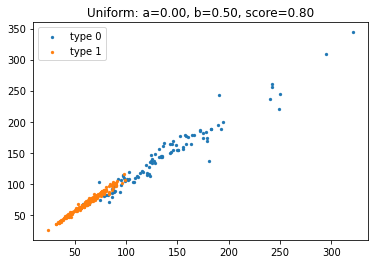

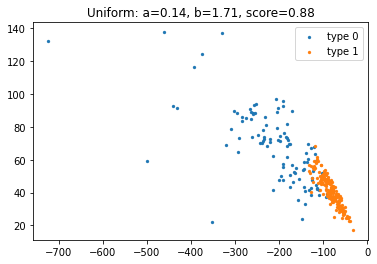

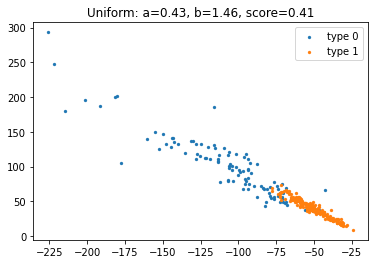

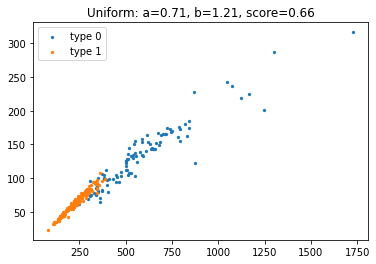

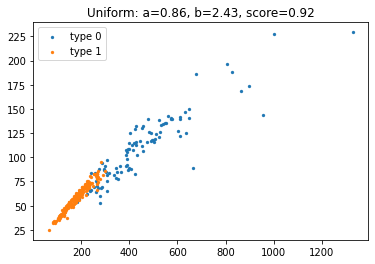

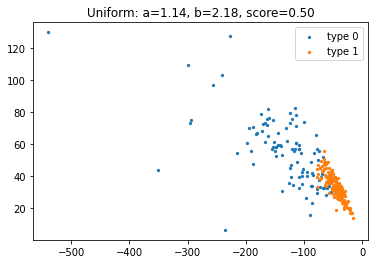

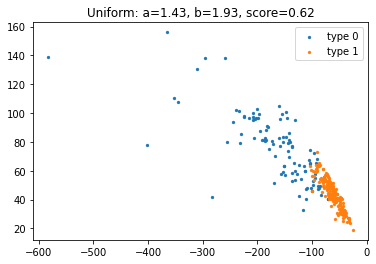

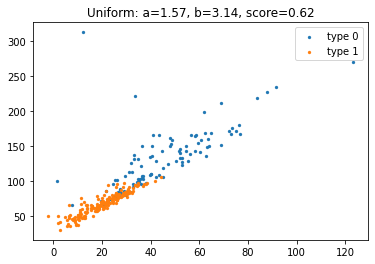

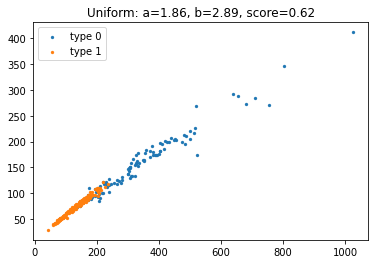


UNIFORM WITH RANDOM FOREST

The 10 best performing parameters are :
	a	b	score
	--------------------
	0.00&	1.25&	0.926\\
	0.86&	2.43&	0.919\\
	1.00&	1.93&	0.912\\
	0.86&	1.89&	0.909\\
	0.00&	1.68&	0.909\\
	1.00&	2.46&	0.902\\
	1.00&	2.68&	0.898\\
	1.71&	2.54&	0.895\\
	0.00&	1.46&	0.888\\
	0.86&	2.54&	0.884\\
The 10 worst performing parameters are :
	a	b	score
	--------------------
	1.43&	2.46&	0.382\\
	1.43&	2.04&	0.382\\
	1.14&	2.82&	0.382\\
	0.57&	1.07&	0.382\\
	0.71&	1.32&	0.382\\
	1.00&	2.04&	0.382\\
	0.86&	2.86&	0.382\\
	0.86&	1.57&	0.382\\
	1.29&	2.43&	0.372\\
	1.00&	2.89&	0.337\\


In [44]:
# test uniform with random forest
# get the scores
scores = uniform_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    RandomForestClassifier, {'n_estimators':50, 'max_depth':10}
)

print('\nUNIFORM WITH RANDOM FOREST\n')

# print the best results
best_performance = np.argsort(scores[:,2])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    a,b,score = scores[best]
    print(row_format.format(a=a,b=b,score=score))

# print the worst results
worst_performance = np.argsort(scores[:,2])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    a,b,score = scores[worst]
    print(row_format.format(a=a,b=b,score=score))

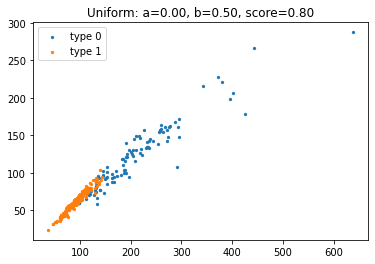

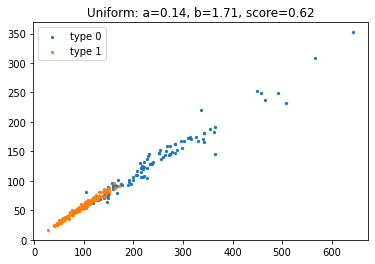

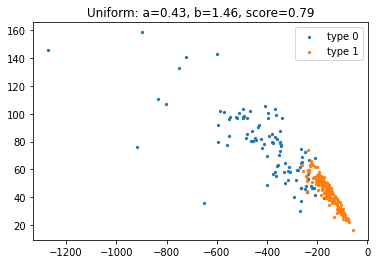

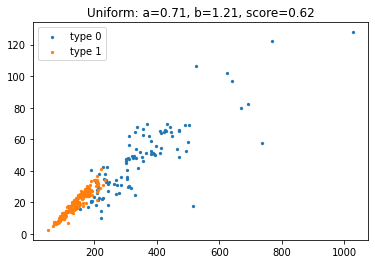

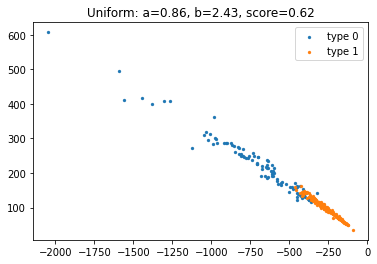

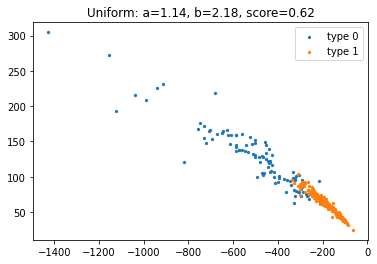

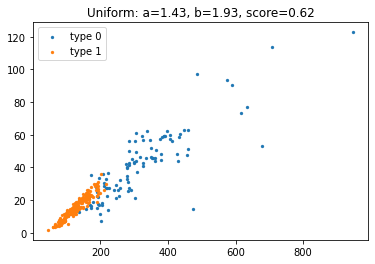

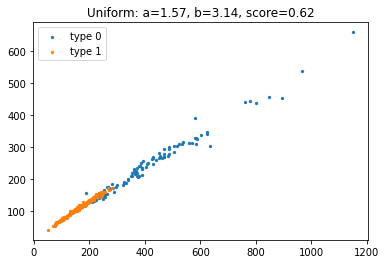

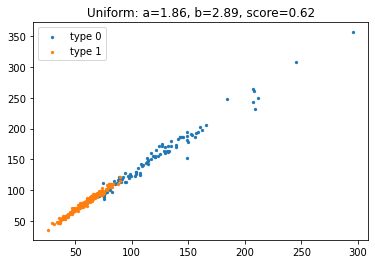


UNIFORM WITH K-NEIGHBORS

The 10 best performing parameters are :
	a	b	score
	--------------------
	0.71&	1.32&	0.912\\
	1.86&	2.46&	0.909\\
	0.86&	1.46&	0.905\\
	1.14&	2.29&	0.905\\
	0.86&	2.86&	0.902\\
	0.43&	2.00&	0.891\\
	0.29&	2.07&	0.888\\
	1.14&	2.07&	0.881\\
	1.86&	2.68&	0.877\\
	1.14&	3.14&	0.877\\
The 10 worst performing parameters are :
	a	b	score
	--------------------
	1.71&	2.43&	0.389\\
	1.00&	2.68&	0.389\\
	1.29&	2.54&	0.382\\
	1.43&	3.32&	0.382\\
	1.57&	3.04&	0.382\\
	1.86&	3.21&	0.382\\
	2.00&	3.04&	0.382\\
	2.00&	3.14&	0.382\\
	2.00&	3.57&	0.382\\
	1.57&	2.71&	0.382\\


In [45]:
# test uniform with k-neighbors classifier
scores = uniform_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    KNeighborsClassifier, {'n_neighbors':3}, plot=True
)

print('\nUNIFORM WITH K-NEIGHBORS\n')

# print the best results
best_performance = np.argsort(scores[:,2])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    a,b,score = scores[best]
    print(row_format.format(a=a,b=b,score=score))

# print the worst results
worst_performance = np.argsort(scores[:,2])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\ta\tb\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    a,b,score = scores[worst]
    print(row_format.format(a=a,b=b,score=score))

In [46]:
# do gamma testing
def gamma_testing(X_train,y_train,X_test,y_test,n,Classifier,params,plot=True):


    as_ = gamma_params['a']
    scales = gamma_params['scale']
    i=0
    scores = np.zeros((len(as_)*len(scales),3))
    

    for a in as_:
        for scale in scales:
            # first we apply noise
            X_train_noise = noiser(X_train, 'gamma', (a,0,scale))
            X_test_noise = noiser(X_test, 'gamma', (a,0,scale))

            # next we apply pca
            train_data = pca(X_train_noise)
            test_data = pca(X_test_noise)

            # finally we test and train a classifier and examine the 
            # score
            classifier = Classifier(**params)
            classifier.fit(train_data, y_train)

            # score the classifier and record it 
            score = sum(classifier.predict(test_data) == y_test) / len(y_test)
            scores[i] = (a,1/scale,score)

            # every once and a while we plot the results
            if i%25 == 0 and plot:
                title_format = 'Gamma: a={a:.2f}, b={b:.2f}, score={score:.2f}'
                title = title_format.format(a=a, b=1/scale, score=scores[i,2])
                plot_data(train_data, y_train, n, title)


            i+=1

    return scores

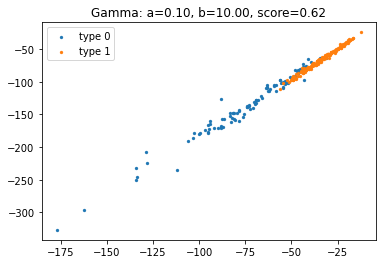

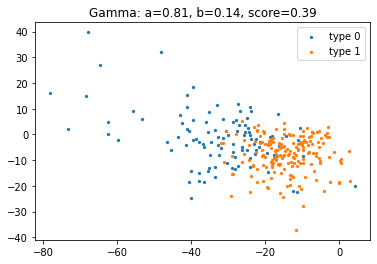

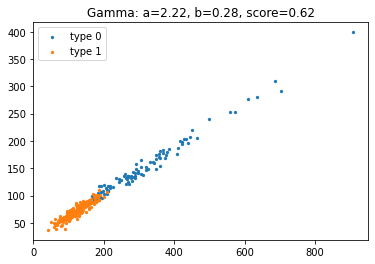

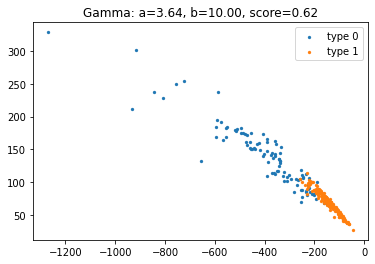

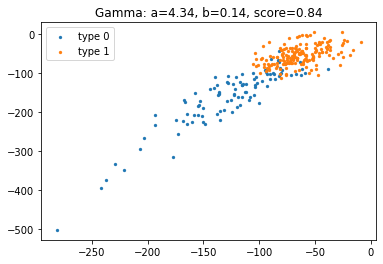

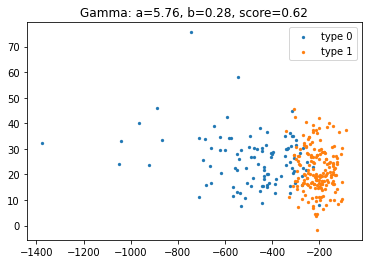

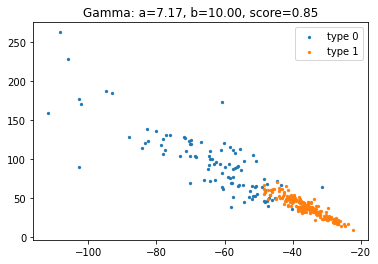

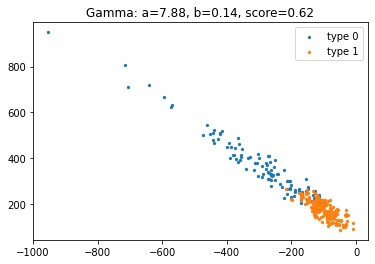

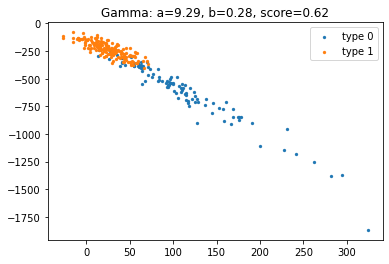


GAMMA WITH RANDOM FOREST

The 10 best performing parameters are :
	a	b	score
	------------------
	2.22&	0.45&	0.909\\
	3.64&	0.34&	0.895\\
	10.00&	0.28&	0.891\\
	0.81&	0.23&	0.891\\
	0.81&	0.17&	0.881\\
	1.51&	0.14&	0.877\\
	0.10&	0.15&	0.870\\
	8.59&	0.11&	0.867\\
	1.51&	0.28&	0.867\\
	7.17&	10.00&	0.846\\
The 10 worst performing parameters are :
	a	b	score
	------------------
	2.93&	0.20&	0.382\\
	8.59&	0.20&	0.382\\
	8.59&	1.24&	0.382\\
	7.88&	0.10&	0.382\\
	2.22&	10.00&	0.382\\
	7.88&	0.17&	0.382\\
	3.64&	1.24&	0.382\\
	9.29&	10.00&	0.382\\
	1.51&	0.66&	0.347\\
	5.76&	0.10&	0.249\\


In [47]:
# test gamma with random forest
# get the scores
scores = gamma_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    RandomForestClassifier, {'n_estimators':50, 'max_depth':10}
)

print('\nGAMMA WITH RANDOM FOREST\n')

# print the best results
best_performance = np.argsort(scores[:,2])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\tdf\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    a,b,score = scores[best]
    print(row_format.format(a=a,b=b,score=score))

# print the worst results
worst_performance = np.argsort(scores[:,2])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\tdf\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    a,b,score = scores[worst]
    print(row_format.format(a=a,b=b,score=score))

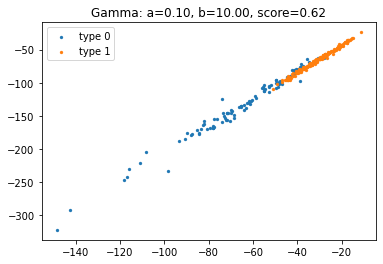

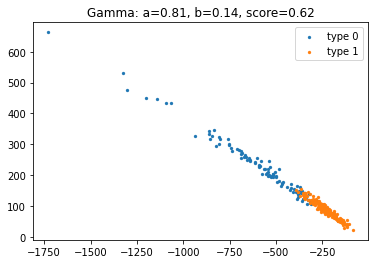

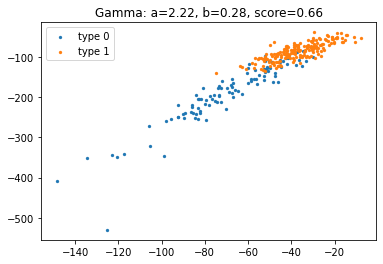

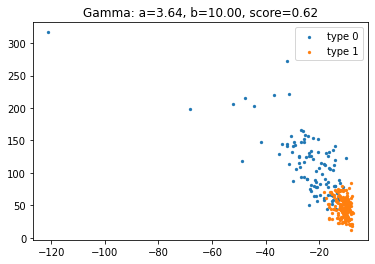

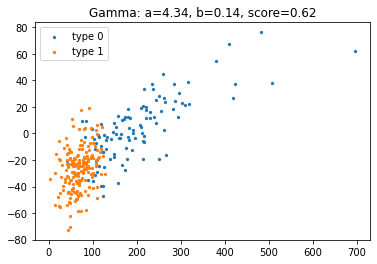

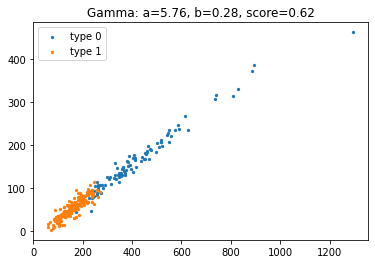

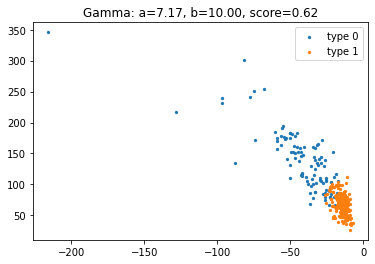

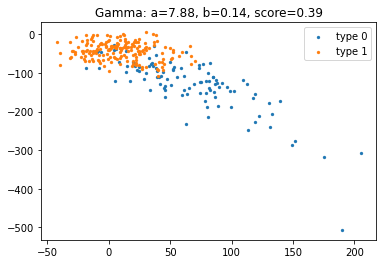

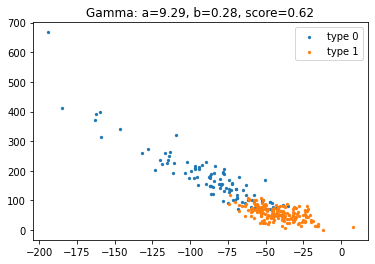


GAMMA WITH K-NEIGHBORS

The 10 best performing parameters are :
	a	b	score
	------------------
	2.22&	0.66&	0.905\\
	1.51&	0.15&	0.898\\
	1.51&	0.20&	0.895\\
	7.88&	0.28&	0.891\\
	0.10&	0.12&	0.888\\
	2.93&	0.13&	0.888\\
	2.93&	0.12&	0.884\\
	4.34&	0.12&	0.881\\
	4.34&	0.23&	0.881\\
	7.17&	0.11&	0.877\\
The 10 worst performing parameters are :
	a	b	score
	------------------
	5.05&	1.24&	0.407\\
	6.46&	0.15&	0.386\\
	4.34&	0.66&	0.386\\
	7.88&	0.14&	0.386\\
	4.34&	0.45&	0.382\\
	1.51&	0.17&	0.382\\
	9.29&	0.10&	0.382\\
	7.88&	1.24&	0.382\\
	0.10&	1.24&	0.382\\
	3.64&	0.28&	0.382\\


In [48]:
# test Gamma with k-neighbors classifier
scores = gamma_testing(
    can_X_train, can_y_train, can_X_test, can_y_test, 2,
    KNeighborsClassifier, {'n_neighbors':3}, plot=True
)

print('\nGAMMA WITH K-NEIGHBORS\n')

# print the best results
best_performance = np.argsort(scores[:,2])[::-1][:10]
print(f'The 10 best performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\tdf\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for best in best_performance:
    a,b,score = scores[best]
    print(row_format.format(a=a,b=b,score=score))

# print the worst results
worst_performance = np.argsort(scores[:,2])[::-1][-10:]
print(f'The 10 worst performing parameters are :')
print('\ta\tb\tscore')
print('\t'+'--'*len('\tdf\tscore'))
row_format = '\t{a:.2f}&\t{b:.2f}&\t{score:.3f}\\\\'
for worst in worst_performance:
    a,b,score = scores[worst]
    print(row_format.format(a=a,b=b,score=score))